In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style for professional aesthetics
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 7) # Standardize plot size
plt.rcParams['figure.dpi'] = 100        # Set plot resolution

# Define the file name
file_name = 'Classes (as of 3 July 2025) - For Dragos.csv'

# Load the dataset using the correct delimiter (';')
try:
    df = pd.read_csv(file_name, delimiter=';')
    print(f"'{file_name}' loaded successfully.")
    print("Initial DataFrame shape:", df.shape)
except FileNotFoundError:
    print(f"Error: '{file_name}' not found. Please ensure the file is uploaded to your Colab environment.")
    # Exit or handle error appropriately in a real notebook
    exit()

# Display initial information and head to verify loading
print("\n--- Initial DataFrame Info (Raw Load) ---")
df.info()
print("\n--- Initial DataFrame Head (Raw Load) ---")
print(df.head())

'Classes (as of 3 July 2025) - For Dragos.csv' loaded successfully.
Initial DataFrame shape: (2058, 365)

--- Initial DataFrame Info (Raw Load) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2058 entries, 0 to 2057
Columns: 365 entries, Day to Unnamed: 364
dtypes: float64(352), object(13)
memory usage: 5.7+ MB

--- Initial DataFrame Head (Raw Load) ---
         Day      Date         Time Class - Type  \
0   Saturday  1-Jun-24  12:30-13:30           团课   
1   Saturday  1-Jun-24  14:15-15:30           团课   
2     Sunday  2-Jun-24  18:30-19:45           团课   
3     Monday  3-Jun-24  12:00-13:00           团课   
4  Wednesday  3-Jun-24  19:30-20:30           团课   

                     Class - Name         Teacher         Venue  \
0  HATHA HIPS AND SHOULDERS | 哈他流         叔叔 (EN)  SANLITUN 三里屯   
1   TWISTING & RELAXATION | 扭转与放松         叔叔 (EN)  SANLITUN 三里屯   
2      BEGINNER'S VINYASA | 初级流瑜伽  Gina (EN | 中文)  SANLITUN 三里屯   
3    LUNCHTIME POWER FLOW | 中午力量流            Jack  SANLIT

/tmp/ipython-input-1-419075451.py:17: DtypeWarning: Columns (0,1,2,3,4,5,6,8,10,11,12,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name, delimiter=';')


In [2]:
# --- 2.1 Clean Column Names ---
# Standardize column names for easier access and consistency
df.columns = df.columns.str.strip().str.replace(' ', '_').str.replace('.', '', regex=False).str.replace(':', '', regex=False).str.replace('/','_').str.replace('|','').str.replace('(','').str.replace(')','').str.replace('-','_').str.replace('+','_').str.replace('*','').str.replace('~','').str.replace('#','')

# Drop any entirely 'Unnamed' columns that result from potential extra delimiters/empty data
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
print("Column names cleaned and 'Unnamed' columns dropped.")
print("DataFrame shape after initial cleaning:", df.shape)

# --- 2.2 Strip Whitespace from String Columns ---
string_cols = ['Day', 'Time', 'Class__Type', 'Class___Name', 'Teacher', 'Venue', 'Misc']
for col in string_cols:
    if col in df.columns:
        df[col] = df[col].astype(str).str.strip()
print("Whitespace stripped from string columns.")

# --- 2.3 Convert 'Date' Column to Datetime Objects ---
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
print(f"'Date' column converted to datetime. Missing dates after conversion: {df['Date'].isnull().sum()}")


# --- 2.4 Convert Numerical Columns to Numeric Type ---
numerical_cols = [
    'No_of_Paying_Students',
    'No_of_YTT_Sudents___Teachers___Free',
    'No_of_Total_Students',
    'Teacher_Payment',
    'Value_Per_Class',
    'Profit_Loss_Per_Class',
    'Value_Per_Paid_Student'
]

print("\nConverting numerical columns to numeric type...")
for col in numerical_cols:
    if col in df.columns:
        # Remove any non-numeric characters (like currency symbols) except decimal point and sign
        df[col] = df[col].astype(str).str.replace(r'[^\d\.\-]', '', regex=True)
        # Convert European decimal format (comma as decimal separator) to standard dot
        if df[col].astype(str).str.contains(',').any(): # Only replace if comma is actually present
            df[col] = df[col].astype(str).str.replace(',', '.')
        # Convert to numeric, coercing errors (non-convertible values become NaN)
        df[col] = pd.to_numeric(df[col], errors='coerce')
        # print(f"'{col}' converted. Missing values: {df[col].isnull().sum()}")
print("Numerical columns conversion complete.")

# --- 2.5 Handle Missing Values and Logical Inconsistencies ---
# Fill NaN in 'No_of_YTT_Sudents___Teachers___Free' with 0 as it represents a count
if 'No_of_YTT_Sudents___Teachers___Free' in df.columns:
    df['No_of_YTT_Sudents___Teachers___Free'] = df['No_of_YTT_Sudents___Teachers___Free'].fillna(0)

# If 'No_of_Paying_Students' is 0, 'Value_Per_Paid_Student' should also be 0 (or NaN if original source has no value)
# Setting it to 0 helps in consistent interpretation for zero-paying classes
if 'Value_Per_Paid_Student' in df.columns and 'No_of_Paying_Students' in df.columns:
    df['Value_Per_Paid_Student'] = df.apply(
        lambda row: 0 if row['No_of_Paying_Students'] == 0 else row['Value_Per_Paid_Student'],
        axis=1
    )

# Recalculate 'No_of_Total_Students' if it's missing or inconsistent, based on its components
if 'No_of_Total_Students' in df.columns and df['No_of_Paying_Students'].notnull().all() and df['No_of_YTT_Sudents___Teachers___Free'].notnull().all():
    df['No_of_Total_Students'] = df['No_of_Paying_Students'] + df['No_of_YTT_Sudents___Teachers___Free']
    print("Recalculated 'No_of_Total_Students'.")

# Drop rows where essential numerical data (like revenue, profit, paying students) is still missing
df.dropna(subset=['Value_Per_Class', 'Profit_Loss_Per_Class', 'No_of_Paying_Students', 'No_of_Total_Students', 'Date'], inplace=True)
print(f"Dropped rows with missing essential data. Final DataFrame shape: {df.shape}")


# --- Final Check After Cleaning ---
print("\n--- Final DataFrame Info After Cleaning ---")
df.info()
print("\n--- Final DataFrame Head After Cleaning ---")
print(df.head())

# --- IMPORTANT: Save the cleaned DataFrame to a CSV file ---
# This file can be reloaded directly in future sessions if you restart Colab
df.to_csv('cleaned_classes_data.csv', index=False)
print("\nCleaned data saved to 'cleaned_classes_data.csv'.")

Column names cleaned and 'Unnamed' columns dropped.
DataFrame shape after initial cleaning: (2058, 15)
Whitespace stripped from string columns.
'Date' column converted to datetime. Missing dates after conversion: 403

Converting numerical columns to numeric type...


/tmp/ipython-input-2-2255685687.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype(str).str.strip()
/tmp/ipython-input-2-2255685687.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype(str).str.strip()
/tmp/ipython-input-2-2255685687.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas

Numerical columns conversion complete.
Dropped rows with missing essential data. Final DataFrame shape: (1649, 15)

--- Final DataFrame Info After Cleaning ---
<class 'pandas.core.frame.DataFrame'>
Index: 1649 entries, 0 to 1654
Data columns (total 15 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   Day                                  1649 non-null   object        
 1   Date                                 1649 non-null   datetime64[ns]
 2   Time                                 1649 non-null   object        
 3   Class___Type                         1649 non-null   object        
 4   Class___Name                         1649 non-null   object        
 5   Teacher                              1649 non-null   object        
 6   Venue                                1649 non-null   object        
 7   No_of_Paying_Students                1649 non-null   float64       
 8   Mis

In [3]:
# --- 3.1 Create YearMonth for Temporal Analysis ---
df['YearMonth'] = df['Date'].dt.to_period('M')

# --- 3.2 Extract Start Hour and Create Time Categories for Scheduling Analysis ---
df['Start_Hour'] = df['Time'].astype(str).apply(lambda x: int(x.split('-')[0].split(':')[0]) if '-' in x else None)

def get_time_category(hour):
    if 5 <= hour < 12:
        return 'Morning (05:00-11:59)'
    elif 12 <= hour < 15:
        return 'Lunchtime (12:00-14:59)'
    elif 15 <= hour < 18:
        return 'Afternoon (15:00-17:59)'
    elif 18 <= hour <= 23:
        return 'Evening (18:00-23:59)'
    else:
        return 'Other' # For any hours outside these ranges or parse errors

df['Time_Category'] = df['Start_Hour'].apply(get_time_category)

# Ensure consistent order for 'Day' and 'Time_Category' for plotting
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['Day'] = pd.Categorical(df['Day'], categories=day_order, ordered=True)

time_category_order = ['Morning (05:00-11:59)', 'Lunchtime (12:00-14:59)', 'Afternoon (15:00-17:59)', 'Evening (18:00-23:59)', 'Other']
df['Time_Category'] = pd.Categorical(df['Time_Category'], categories=time_category_order, ordered=True)

print("Feature engineering: 'YearMonth', 'Start_Hour', and 'Time_Category' created.")


# --- 3.3 Calculate Teacher-Class Tenure ---
# Create a unique identifier for each teacher-class combination
df['Teacher_Class_Combo'] = df['Teacher'] + ' - ' + df['Class___Name']

# Find the earliest date for each unique teacher-class combination within the dataset
teacher_class_first_dates = df.groupby('Teacher_Class_Combo')['Date'].min().reset_index()
teacher_class_first_dates.rename(columns={'Date': 'Class_Teacher_StartDate'}, inplace=True)

# Merge this start date back to the original DataFrame
df = pd.merge(df, teacher_class_first_dates, on='Teacher_Class_Combo', how='left')

# Calculate the "tenure" for each class instance in months
df['Tenure_Days'] = (df['Date'] - df['Class_Teacher_StartDate']).dt.days
df['Tenure_Months'] = df['Tenure_Days'] / 30.44 # Approximate months for categorization

# Categorize tenure into groups
bins = [-1, 3, 6, 12, df['Tenure_Months'].max() + 1] # -1 to include 0 months, max()+1 for upper bound
labels = ['0-3 Months', '4-6 Months', '7-12 Months', 'Over 12 Months']
df['Tenure_Category'] = pd.cut(df['Tenure_Months'], bins=bins, labels=labels, right=True)

# Ensure Tenure_Category order is consistent for plotting
tenure_category_order = ['0-3 Months', '4-6 Months', '7-12 Months', 'Over 12 Months']
df['Tenure_Category'] = pd.Categorical(df['Tenure_Category'], categories=tenure_category_order, ordered=True)

print("Teacher-Class Tenure (Tenure_Days, Tenure_Months, Tenure_Category) calculated.")
print(df[['Date', 'Time', 'Start_Hour', 'Time_Category', 'Teacher', 'Class___Name', 'Tenure_Months', 'Tenure_Category']].head())

Feature engineering: 'YearMonth', 'Start_Hour', and 'Time_Category' created.
Teacher-Class Tenure (Tenure_Days, Tenure_Months, Tenure_Category) calculated.
        Date         Time  Start_Hour            Time_Category  \
0 2024-06-01  12:30-13:30          12  Lunchtime (12:00-14:59)   
1 2024-06-01  14:15-15:30          14  Lunchtime (12:00-14:59)   
2 2024-06-02  18:30-19:45          18    Evening (18:00-23:59)   
3 2024-06-03  12:00-13:00          12  Lunchtime (12:00-14:59)   
4 2024-06-03  19:30-20:30          19    Evening (18:00-23:59)   

          Teacher                    Class___Name  Tenure_Months  \
0         叔叔 (EN)  HATHA HIPS AND SHOULDERS | 哈他流            0.0   
1         叔叔 (EN)   TWISTING & RELAXATION | 扭转与放松            0.0   
2  Gina (EN | 中文)      BEGINNER'S VINYASA | 初级流瑜伽            0.0   
3            Jack    LUNCHTIME POWER FLOW | 中午力量流            0.0   
4      Jacqueline                  YIN YOGA | 阴瑜伽            0.0   

  Tenure_Category  
0      0-3 Months 

In [5]:
# Calculate Overall KPIs
total_revenue = df['Value_Per_Class'].sum()
total_profit_loss = df['Profit_Loss_Per_Class'].sum()
average_paying_students_per_class_overall = df['No_of_Paying_Students'].mean()
average_total_students_per_class_overall = df['No_of_Total_Students'].mean() # Corrected variable name
average_value_per_paid_student_overall = df['Value_Per_Paid_Student'].mean()

print("--- Overall Key Performance Indicators (KPIs) ---")
print(f"Total Revenue: ${total_revenue:,.2f}")
print(f"Total Profit/Loss: ${total_profit_loss:,.2f}")
print(f"Average Paying Students per Class (Overall): {average_paying_students_per_class_overall:.2f}")
print(f"Average Total Students per Class (Overall): {average_total_students_per_class_overall:.2f}") # Corrected line
print(f"Average Value Per Paid Student (Overall): ${average_value_per_paid_student_overall:,.2f}")

# Get unique counts for strategic overview
unique_classes = df['Class___Name'].nunique()
unique_teachers = df['Teacher'].nunique()
unique_venues = df['Venue'].nunique()

print(f"\nNumber of Unique Classes Offered: {unique_classes}")
print(f"Number of Unique Teachers: {unique_teachers}")
print(f"Number of Unique Venues: {unique_venues}")

--- Overall Key Performance Indicators (KPIs) ---
Total Revenue: $610,686.24
Total Profit/Loss: $5,327,595.00
Average Paying Students per Class (Overall): 5.35
Average Total Students per Class (Overall): 6.86
Average Value Per Paid Student (Overall): $81.02

Number of Unique Classes Offered: 53
Number of Unique Teachers: 52
Number of Unique Venues: 7


--- Monthly Performance Trends (Summary) ---
   YearMonth  total_classes  total_paying_students  total_revenue  \
0    2024-06            120                  628.0      47588.483   
1    2024-07            139                  711.0      41286.362   
2    2024-08            129                  644.0      45341.378   
3    2024-09            123                  619.0      46396.198   
4    2024-10            126                  616.0      50175.135   
5    2024-11            131                  610.0      48135.581   
6    2024-12            106                  554.0      45484.004   
7    2025-01            115                  571.0      37769.311   
8    2025-02            118                  769.0      43299.793   
9    2025-03            139                  950.0      58022.172   
10   2025-04            122                  630.0      45779.760   
11   2025-05            131                  699.0      50798.767   
12   2025-06            133                  736.0      45

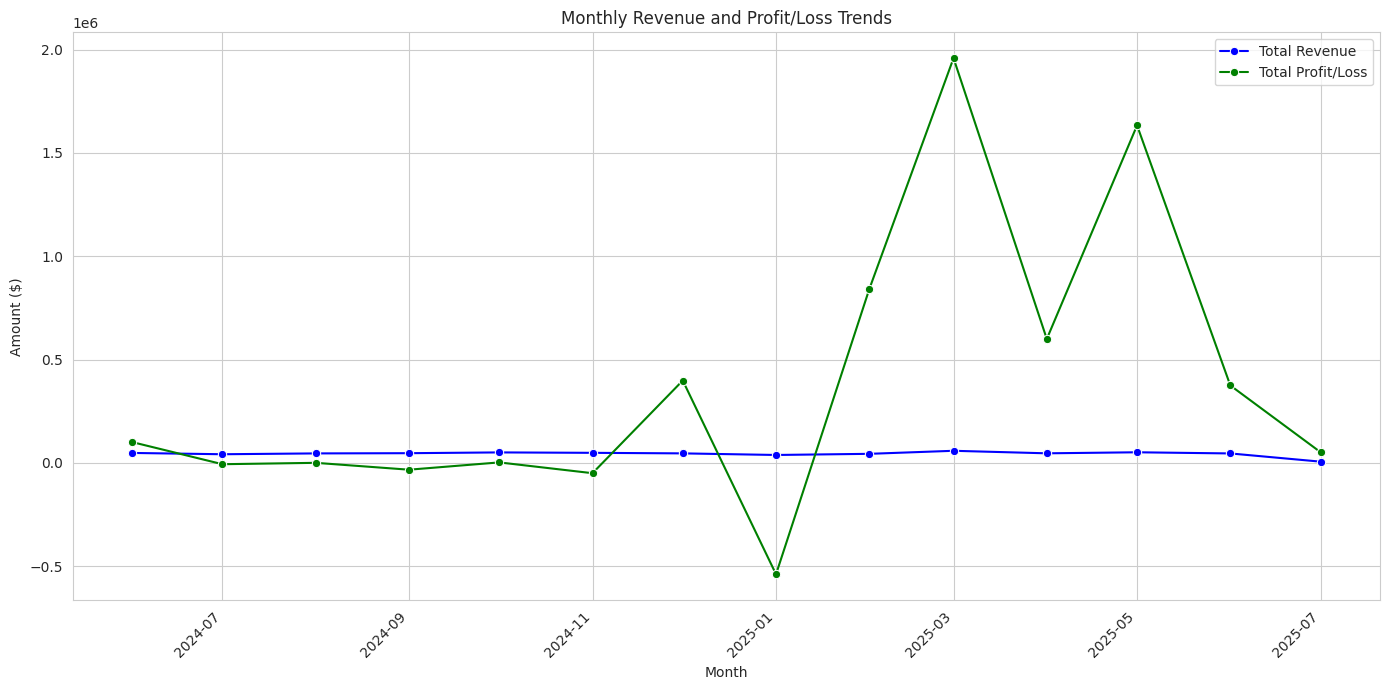

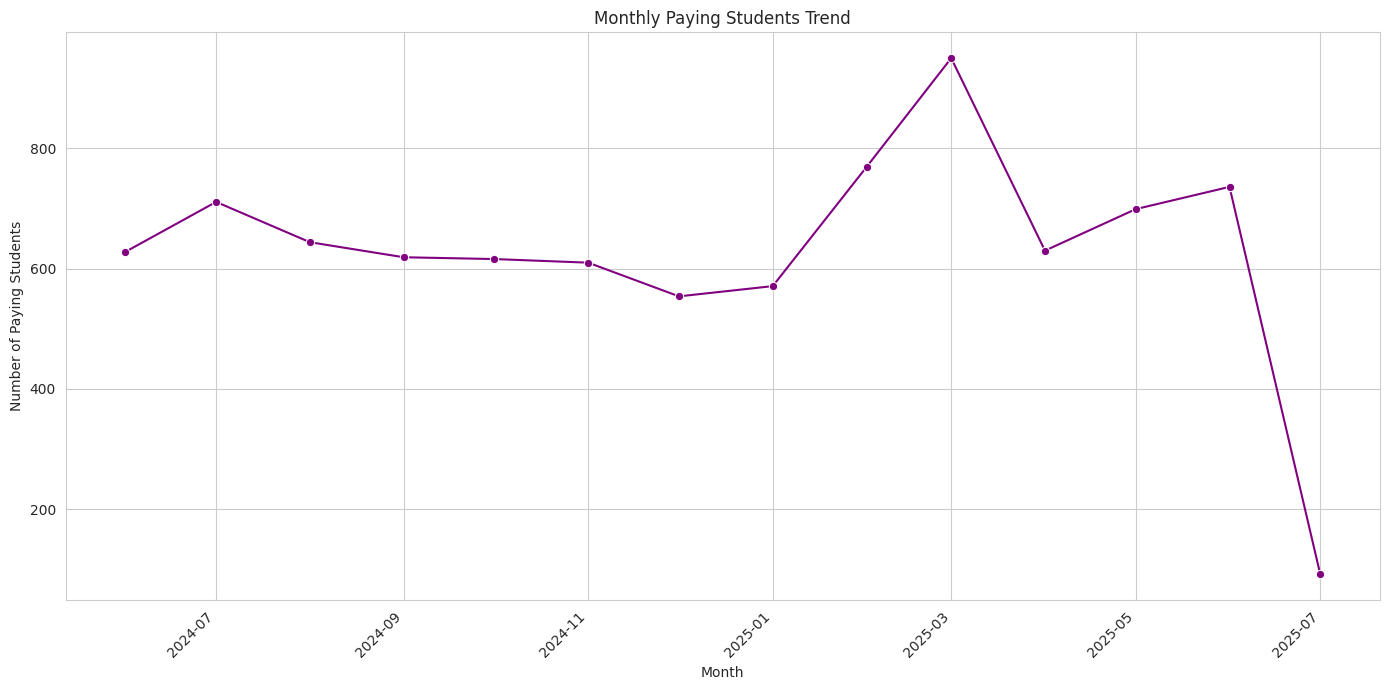

In [6]:
# Aggregate data by month
monthly_trends = df.groupby('YearMonth').agg(
    total_classes=('Class___Name', 'count'),
    total_paying_students=('No_of_Paying_Students', 'sum'),
    total_revenue=('Value_Per_Class', 'sum'),
    total_profit_loss=('Profit_Loss_Per_Class', 'sum'),
    average_paying_students_per_class=('No_of_Paying_Students', 'mean')
).reset_index()

# Convert YearMonth to datetime for plotting
monthly_trends['YearMonth_dt'] = monthly_trends['YearMonth'].dt.to_timestamp()

print("--- Monthly Performance Trends (Summary) ---")
print(monthly_trends)

# Plot: Monthly Revenue and Profit/Loss Trends
plt.figure(figsize=(14, 7))
sns.lineplot(x='YearMonth_dt', y='total_revenue', data=monthly_trends, marker='o', label='Total Revenue', color='blue')
sns.lineplot(x='YearMonth_dt', y='total_profit_loss', data=monthly_trends, marker='o', label='Total Profit/Loss', color='green')
plt.xlabel('Month')
plt.ylabel('Amount ($)')
plt.title('Monthly Revenue and Profit/Loss Trends')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('monthly_revenue_profit_loss_trend.png') # Save plot
plt.show()

# Plot: Monthly Paying Students Trend
plt.figure(figsize=(14, 7))
sns.lineplot(x='YearMonth_dt', y='total_paying_students', data=monthly_trends, marker='o', color='purple')
plt.xlabel('Month')
plt.ylabel('Number of Paying Students')
plt.title('Monthly Paying Students Trend')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()
plt.savefig('monthly_paying_students_trend.png') # Save plot
plt.show()

--- Class Performance Analysis ---

Top 10 Most Popular Classes by Total Paying Students:
                        Class___Name  num_classes  total_paying_students  \
18      LUNCHTIME POWER FLOW | 中午力量流          246                 1651.0   
1   ASHTANGA PRIMARY SERIES | 阿斯汤伽瑜伽          130                  591.0   
5     BODY FLEXIBILITY | 身体柔韧性 (哈他流）          100                  486.0   
3         BEGINNER'S VINYASA | 初级流瑜伽           56                  460.0   
33            VINYASA L1/2 | 流瑜伽1/2级          113                  426.0   
40        YOGA FOR ATHLETES | 运动伸展瑜伽           62                  423.0   
7             ELEMENTAL FLOW | 自然元素流           54                  398.0   
34          VINYASA LEVEL 2 | 瑜伽流 2级          109                  382.0   
10    HATHA HIPS AND SHOULDERS | 哈他流           46                  359.0   
11               HATHA VINYASA | 哈他流           48                  328.0   

    average_paying_students  total_revenue  total_profit_loss  \
18      

/tmp/ipython-input-7-4222175925.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='average_paying_students', y='Class___Name', data=top_popular_classes.sort_values(by='average_paying_students', ascending=False), palette='viridis')
/tmp/ipython-input-7-4222175925.py:24: UserWarning: Glyph 21021 (\N{CJK UNIFIED IDEOGRAPH-521D}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-7-4222175925.py:24: UserWarning: Glyph 32423 (\N{CJK UNIFIED IDEOGRAPH-7EA7}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-7-4222175925.py:24: UserWarning: Glyph 27969 (\N{CJK UNIFIED IDEOGRAPH-6D41}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-7-4222175925.py:24: UserWarning: Glyph 29788 (\N{CJK UNIFIED IDEOGRAPH-745C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/

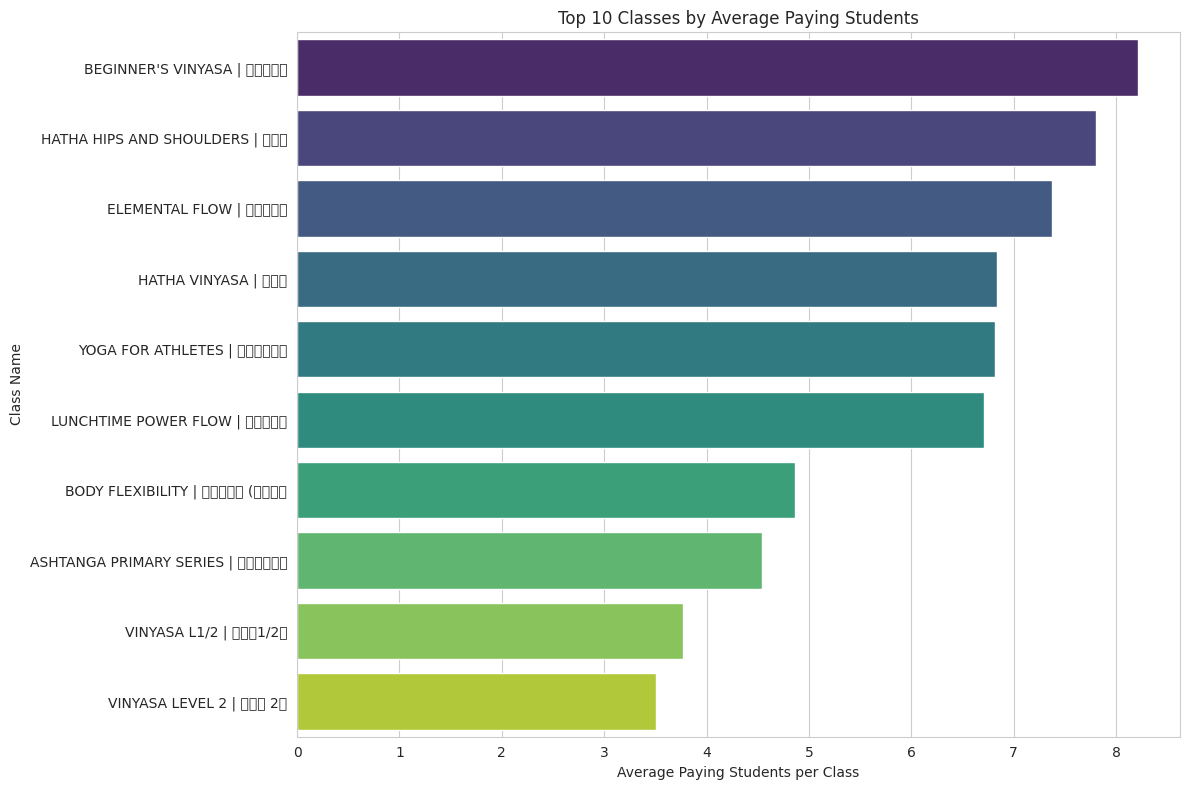


Top 10 Most Profitable Classes (by Total Profit/Loss):
                          Class___Name  num_classes  total_paying_students  \
18        LUNCHTIME POWER FLOW | 中午力量流          246                 1651.0   
3           BEGINNER'S VINYASA | 初级流瑜伽           56                  460.0   
7               ELEMENTAL FLOW | 自然元素流           54                  398.0   
11                 HATHA VINYASA | 哈他流           48                  328.0   
23                PRENATAL YOGA | 产前瑜伽           44                  205.0   
15  LIL’ PEACHES KIDS 儿童 YOGA AGE 4-6岁           11                   78.0   
10      HATHA HIPS AND SHOULDERS | 哈他流           46                  359.0   
16  LIL’ PEACHES KIDS 儿童 YOGA AGE 5-6岁           36                  186.0   
19    MAMA+BABY YOGA-FITNESS | 妈妈和宝宝瑜伽           67                  258.0   
4         BEGINNERS ASHTANGA | 初学者阿斯汤伽           52                  323.0   

    average_paying_students  total_revenue  total_profit_loss  \
18                 6

/tmp/ipython-input-7-4222175925.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='total_profit_loss', y='Class___Name', data=top_profitable_classes, palette='magma')
/tmp/ipython-input-7-4222175925.py:39: UserWarning: Glyph 20013 (\N{CJK UNIFIED IDEOGRAPH-4E2D}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-7-4222175925.py:39: UserWarning: Glyph 21320 (\N{CJK UNIFIED IDEOGRAPH-5348}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-7-4222175925.py:39: UserWarning: Glyph 21147 (\N{CJK UNIFIED IDEOGRAPH-529B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-7-4222175925.py:39: UserWarning: Glyph 37327 (\N{CJK UNIFIED IDEOGRAPH-91CF}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-7-4222175925.py:39: UserWarning: Glyph 27969 (\N{C

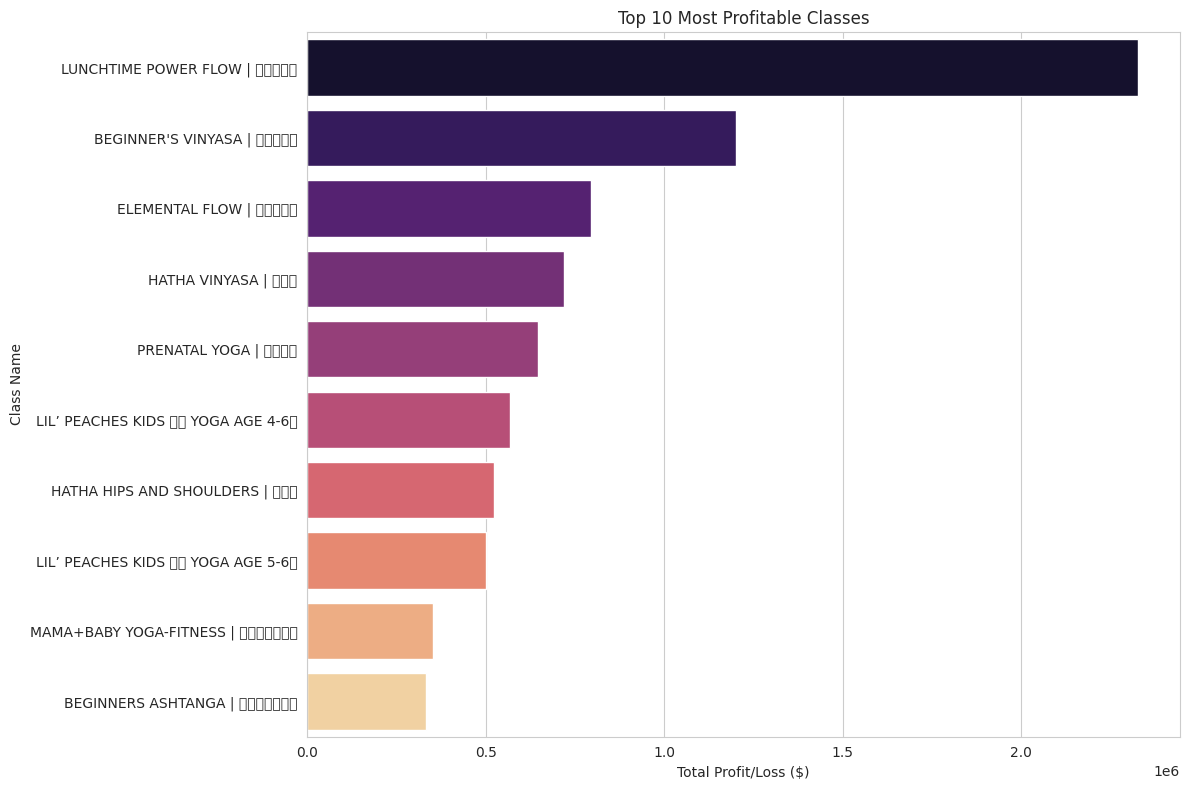


Top 10 Least Profitable / Loss-Making Classes (by Total Profit/Loss):
                        Class___Name  num_classes  total_paying_students  \
1   ASHTANGA PRIMARY SERIES | 阿斯汤伽瑜伽          130                  591.0   
33            VINYASA L1/2 | 流瑜伽1/2级          113                  426.0   
34          VINYASA LEVEL 2 | 瑜伽流 2级          109                  382.0   
46                ✨HATHA YOGA | 哈他瑜伽           10                   20.0   
24  RESTORATIVE + MEDITATION | 恢复与冥想           63                  249.0   
51       ✨YOGA FOR ATHLETES | 运动伸展瑜伽            5                   11.0   
21          MYOFASCIA RELEASE | 筋膜释放           40                  156.0   
25            RESTORATIVE FLOW | 疗愈流            9                   27.0   
52          ✨YOGA FOR RUNNERS | 跑者瑜伽            4                    6.0   
27                 ROCKET FLOW | 火箭流           11                   43.0   

    average_paying_students  total_revenue  total_profit_loss  \
1                  4.546154

/tmp/ipython-input-7-4222175925.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='total_profit_loss', y='Class___Name', data=least_profitable_classes, palette='cividis')
/tmp/ipython-input-7-4222175925.py:54: UserWarning: Glyph 38463 (\N{CJK UNIFIED IDEOGRAPH-963F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-7-4222175925.py:54: UserWarning: Glyph 26031 (\N{CJK UNIFIED IDEOGRAPH-65AF}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-7-4222175925.py:54: UserWarning: Glyph 27748 (\N{CJK UNIFIED IDEOGRAPH-6C64}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-7-4222175925.py:54: UserWarning: Glyph 20285 (\N{CJK UNIFIED IDEOGRAPH-4F3D}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-7-4222175925.py:54: UserWarning: Glyph 29788 (

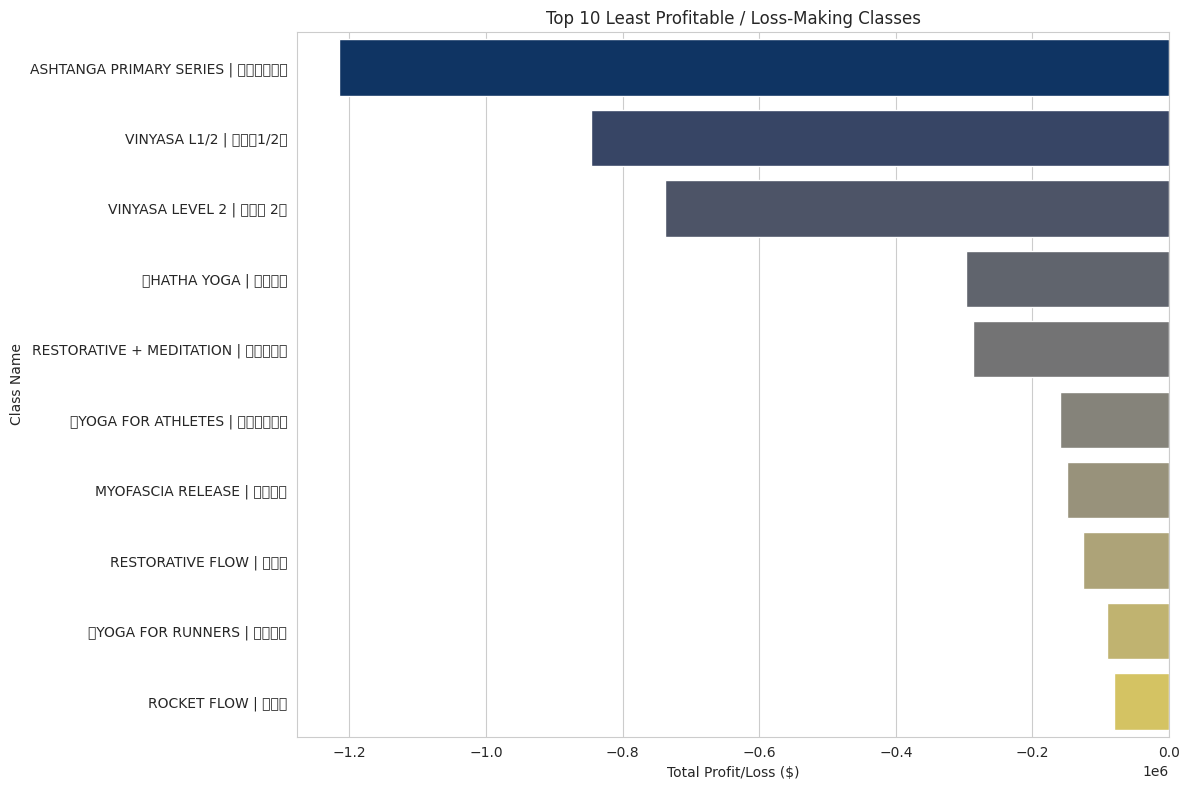

In [7]:
# Aggregate data by Class Name
class_performance = df.groupby('Class___Name').agg(
    num_classes=('Class___Name', 'count'),
    total_paying_students=('No_of_Paying_Students', 'sum'),
    average_paying_students=('No_of_Paying_Students', 'mean'),
    total_revenue=('Value_Per_Class', 'sum'),
    total_profit_loss=('Profit_Loss_Per_Class', 'sum'),
    average_profit_loss=('Profit_Loss_Per_Class', 'mean')
).reset_index()

print("--- Class Performance Analysis ---")

# Top 10 Most Popular Classes by Total Paying Students
top_popular_classes = class_performance.sort_values(by='total_paying_students', ascending=False).head(10)
print("\nTop 10 Most Popular Classes by Total Paying Students:")
print(top_popular_classes)

# Plot: Top 10 Most Popular Classes by Average Paying Students
plt.figure(figsize=(12, 8))
sns.barplot(x='average_paying_students', y='Class___Name', data=top_popular_classes.sort_values(by='average_paying_students', ascending=False), palette='viridis')
plt.xlabel('Average Paying Students per Class')
plt.ylabel('Class Name')
plt.title('Top 10 Classes by Average Paying Students')
plt.tight_layout()
plt.savefig('top_10_classes_by_avg_students.png') # Save plot
plt.show()

# Top 10 Most Profitable Classes
top_profitable_classes = class_performance.sort_values(by='total_profit_loss', ascending=False).head(10)
print("\nTop 10 Most Profitable Classes (by Total Profit/Loss):")
print(top_profitable_classes)

# Plot: Top 10 Most Profitable Classes
plt.figure(figsize=(12, 8))
sns.barplot(x='total_profit_loss', y='Class___Name', data=top_profitable_classes, palette='magma')
plt.xlabel('Total Profit/Loss ($)')
plt.ylabel('Class Name')
plt.title('Top 10 Most Profitable Classes')
plt.tight_layout()
plt.savefig('top_10_most_profitable_classes.png') # Save plot
plt.show()

# Top 10 Least Profitable / Loss-Making Classes
least_profitable_classes = class_performance.sort_values(by='total_profit_loss', ascending=True).head(10)
print("\nTop 10 Least Profitable / Loss-Making Classes (by Total Profit/Loss):")
print(least_profitable_classes)

# Plot: Top 10 Least Profitable / Loss-Making Classes
plt.figure(figsize=(12, 8))
sns.barplot(x='total_profit_loss', y='Class___Name', data=least_profitable_classes, palette='cividis')
plt.xlabel('Total Profit/Loss ($)')
plt.ylabel('Class Name')
plt.title('Top 10 Least Profitable / Loss-Making Classes')
plt.tight_layout()
plt.savefig('top_10_least_profitable_classes.png') # Save plot
plt.show()

--- Teacher Performance Analysis ---

Top Teachers by Average Paying Students per Class:
                   Teacher  num_classes_taught  total_paying_students  \
39                 Shandre                   2                   23.0   
22              Jacqueline                  10                   93.0   
47                Wang Lei                   1                    9.0   
44              Sunny (EN)                   1                    9.0   
46  Theresa 桃子老师 (EN | 中文)                 114                  966.0   
2         Ana 西雅 (EN | RU)                  14                  117.0   
20           Guest Teacher                   3                   25.0   
16          Gina (EN | 中文)                  46                  370.0   
32       Monica - 晨芳雪 (EN)                  79                  566.0   
0     Alessandra (EN | IT)                  26                  185.0   

    average_paying_students_per_class  total_revenue_generated  \
39                          11.500000    

/tmp/ipython-input-8-1331124284.py:61: UserWarning: Glyph 26691 (\N{CJK UNIFIED IDEOGRAPH-6843}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-8-1331124284.py:61: UserWarning: Glyph 23376 (\N{CJK UNIFIED IDEOGRAPH-5B50}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-8-1331124284.py:61: UserWarning: Glyph 32769 (\N{CJK UNIFIED IDEOGRAPH-8001}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-8-1331124284.py:61: UserWarning: Glyph 24072 (\N{CJK UNIFIED IDEOGRAPH-5E08}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-8-1331124284.py:61: UserWarning: Glyph 20013 (\N{CJK UNIFIED IDEOGRAPH-4E2D}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-8-1331124284.py:61: UserWarning: Glyph 25991 (\N{CJK UNIFIED IDEOGRAPH-6587}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-8-1331124284.py:61: UserWarning: Glyph 35199 (\N{CJK UNIFIED IDEOGRAP

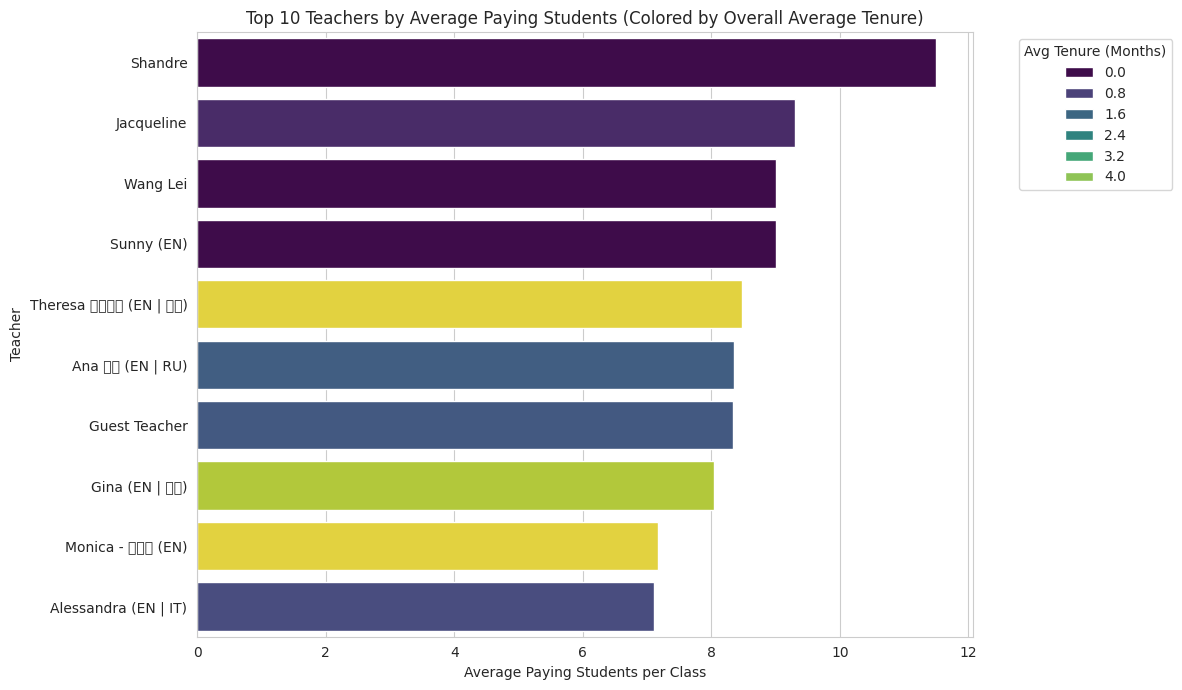

/tmp/ipython-input-8-1331124284.py:79: UserWarning: Glyph 35199 (\N{CJK UNIFIED IDEOGRAPH-897F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-8-1331124284.py:79: UserWarning: Glyph 38597 (\N{CJK UNIFIED IDEOGRAPH-96C5}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-8-1331124284.py:79: UserWarning: Glyph 26216 (\N{CJK UNIFIED IDEOGRAPH-6668}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-8-1331124284.py:79: UserWarning: Glyph 33459 (\N{CJK UNIFIED IDEOGRAPH-82B3}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-8-1331124284.py:79: UserWarning: Glyph 38634 (\N{CJK UNIFIED IDEOGRAPH-96EA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-8-1331124284.py:79: UserWarning: Glyph 20013 (\N{CJK UNIFIED IDEOGRAPH-4E2D}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-8-1331124284.py:79: UserWarning: Glyph 25991 (\N{CJK UNIFIED IDEOGRAP

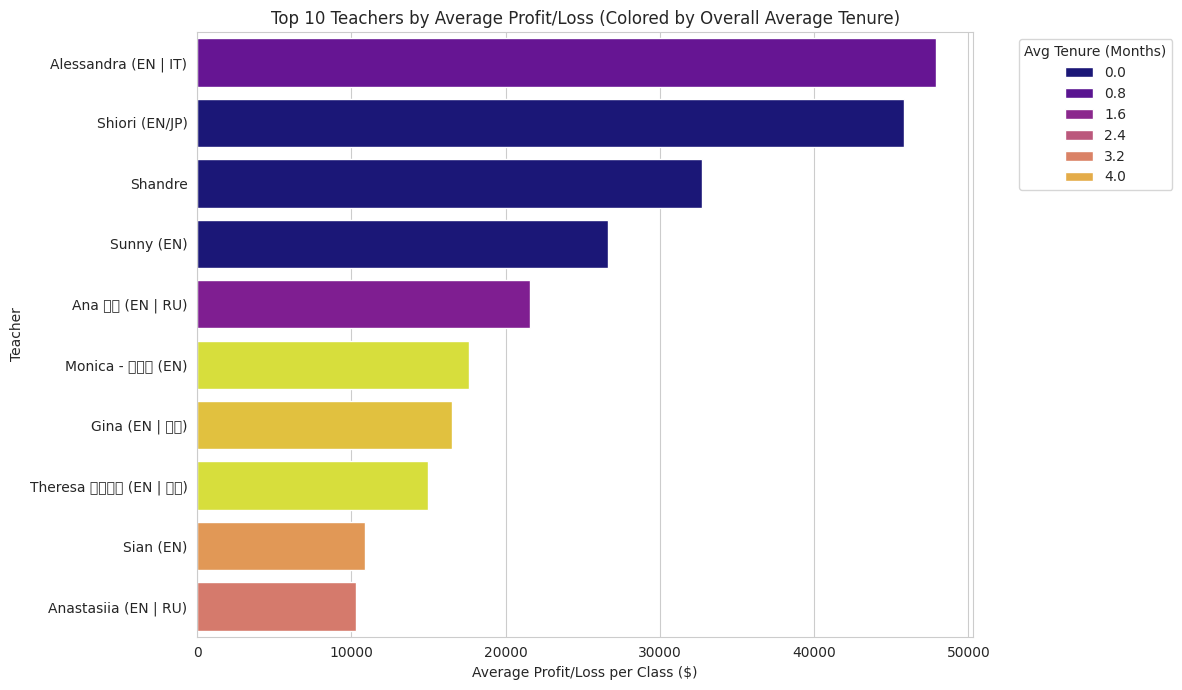

In [8]:
# Aggregate data by Teacher
teacher_performance = df.groupby('Teacher').agg(
    num_classes_taught=('Class___Name', 'count'),
    total_paying_students=('No_of_Paying_Students', 'sum'),
    average_paying_students_per_class=('No_of_Paying_Students', 'mean'),
    total_revenue_generated=('Value_Per_Class', 'sum'),
    total_profit_loss_contribution=('Profit_Loss_Per_Class', 'sum'),
    average_profit_loss_per_class=('Profit_Loss_Per_Class', 'mean')
).reset_index()

print("--- Teacher Performance Analysis ---")

# Top Teachers by Average Paying Students per Class (normalized performance)
top_teachers_by_avg_students = teacher_performance.sort_values(by='average_paying_students_per_class', ascending=False)
print("\nTop Teachers by Average Paying Students per Class:")
print(top_teachers_by_avg_students.head(10))

# Top Teachers by Average Profit/Loss per Class (normalized performance)
top_teachers_by_avg_profit = teacher_performance.sort_values(by='average_profit_loss_per_class', ascending=False)
print("\nTop Teachers by Average Profit/Loss per Class:")
print(top_teachers_by_avg_profit.head(10))

# Teachers with Negative Total Profit/Loss Contribution
unprofitable_teachers = teacher_performance[teacher_performance['total_profit_loss_contribution'] < 0].sort_values(by='total_profit_loss_contribution', ascending=True)
if not unprofitable_teachers.empty:
    print("\nTeachers with Negative Total Profit/Loss Contribution:")
    print(unprofitable_teachers)
else:
    print("\nNo teachers with negative total profit/loss contribution found in this period.")

# Recalculate teacher_performance including average tenure for overall teacher plots
teacher_performance_with_tenure = df.groupby('Teacher').agg(
    num_classes_taught=('Class___Name', 'count'),
    total_paying_students=('No_of_Paying_Students', 'sum'),
    average_paying_students_per_class=('No_of_Paying_Students', 'mean'),
    total_revenue_generated=('Value_Per_Class', 'sum'),
    total_profit_loss_contribution=('Profit_Loss_Per_Class', 'sum'),
    average_profit_loss_per_class=('Profit_Loss_Per_Class', 'mean'),
    average_value_per_paid_student_overall=('Value_Per_Paid_Student', 'mean'),
    average_teacher_tenure_overall=('Tenure_Months', 'mean') # Average tenure across all classes taught by this teacher
).reset_index()

# Get top teachers by average students and profit for plotting
top_teachers_by_avg_students_plot_data = teacher_performance_with_tenure.sort_values(by='average_paying_students_per_class', ascending=False).head(10)
top_teachers_by_avg_profit_plot_data = teacher_performance_with_tenure.sort_values(by='average_profit_loss_per_class', ascending=False).head(10)


# --- Plot: Top Teachers by Average Students per Class (colored by overall average tenure) ---
plt.figure(figsize=(12, 7))
sns.barplot(
    x='average_paying_students_per_class',
    y='Teacher',
    hue='average_teacher_tenure_overall', # Use average tenure as hue
    data=top_teachers_by_avg_students_plot_data,
    palette='viridis' # Choose a color palette
)
plt.xlabel('Average Paying Students per Class')
plt.ylabel('Teacher')
plt.title('Top 10 Teachers by Average Paying Students (Colored by Overall Average Tenure)')
plt.legend(title='Avg Tenure (Months)', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('top_teachers_avg_students_by_overall_tenure.png') # Save plot
plt.show()


# --- Plot: Top Teachers by Average Profit/Loss per Class (colored by overall average tenure) ---
plt.figure(figsize=(12, 7))
sns.barplot(
    x='average_profit_loss_per_class',
    y='Teacher',
    hue='average_teacher_tenure_overall', # Use average tenure as hue
    data=top_teachers_by_avg_profit_plot_data,
    palette='plasma' # Another color palette
)
plt.xlabel('Average Profit/Loss per Class ($)')
plt.ylabel('Teacher')
plt.title('Top 10 Teachers by Average Profit/Loss (Colored by Overall Average Tenure)')
plt.legend(title='Avg Tenure (Months)', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('top_teachers_avg_profit_by_overall_tenure.png') # Save plot
plt.show()

--- Venue Performance Analysis ---
                              Venue  num_classes  total_paying_students  \
5                      SANLITUN 三里屯         1527                 8194.0   
3                     JINSHANG 金尚·源          110                  544.0   
6  SANLITUN 三里屯 (RM. 306) - TAOZI T            7                   49.0   
0                Chaoyang Park 朝阳公园            2                   26.0   
2      Hotel Eclat Beijing | 北京怡亨酒店            1                   12.0   
1   Hotel Eclat + George's | 北京怡亨酒店            1                    2.0   
4   Jinshang Yuan | 金尚·源 - Wellness            1                    2.0   

   average_paying_students_per_class  total_revenue  total_profit_loss  \
5                           5.366077     571241.729          4620267.0   
3                           4.945455      37394.636           272046.0   
6                           7.000000        391.185           243782.0   
0                          13.000000       1461.000           111100

/tmp/ipython-input-9-400804948.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='total_paying_students', y='Venue', data=venue_performance, palette='viridis')
/tmp/ipython-input-9-400804948.py:20: UserWarning: Glyph 19977 (\N{CJK UNIFIED IDEOGRAPH-4E09}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-9-400804948.py:20: UserWarning: Glyph 37324 (\N{CJK UNIFIED IDEOGRAPH-91CC}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-9-400804948.py:20: UserWarning: Glyph 23663 (\N{CJK UNIFIED IDEOGRAPH-5C6F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-9-400804948.py:20: UserWarning: Glyph 37329 (\N{CJK UNIFIED IDEOGRAPH-91D1}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-9-400804948.py:20: UserWarning: Glyph 23578 (\N{CJK UNIFIED I

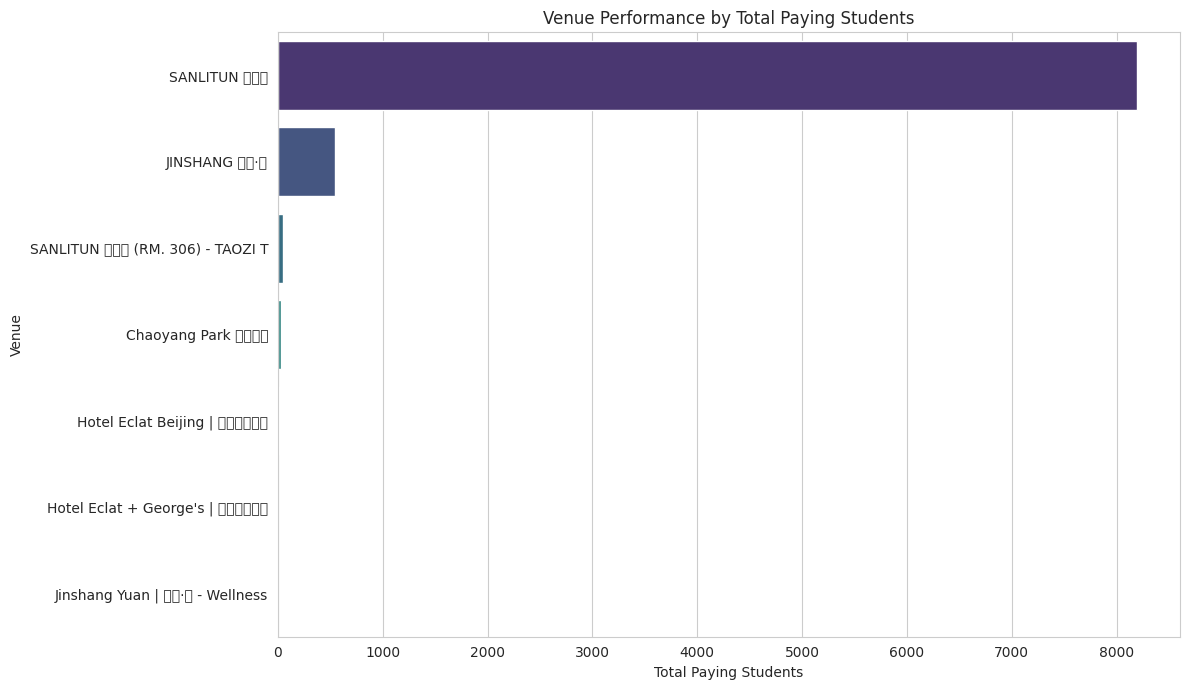

/tmp/ipython-input-9-400804948.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='total_profit_loss', y='Venue', data=venue_performance, palette='magma')
/tmp/ipython-input-9-400804948.py:30: UserWarning: Glyph 19977 (\N{CJK UNIFIED IDEOGRAPH-4E09}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-9-400804948.py:30: UserWarning: Glyph 37324 (\N{CJK UNIFIED IDEOGRAPH-91CC}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-9-400804948.py:30: UserWarning: Glyph 23663 (\N{CJK UNIFIED IDEOGRAPH-5C6F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-9-400804948.py:30: UserWarning: Glyph 37329 (\N{CJK UNIFIED IDEOGRAPH-91D1}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-9-400804948.py:30: UserWarning: Glyph 23578 (\N{CJK UNIFIED IDEOGRA

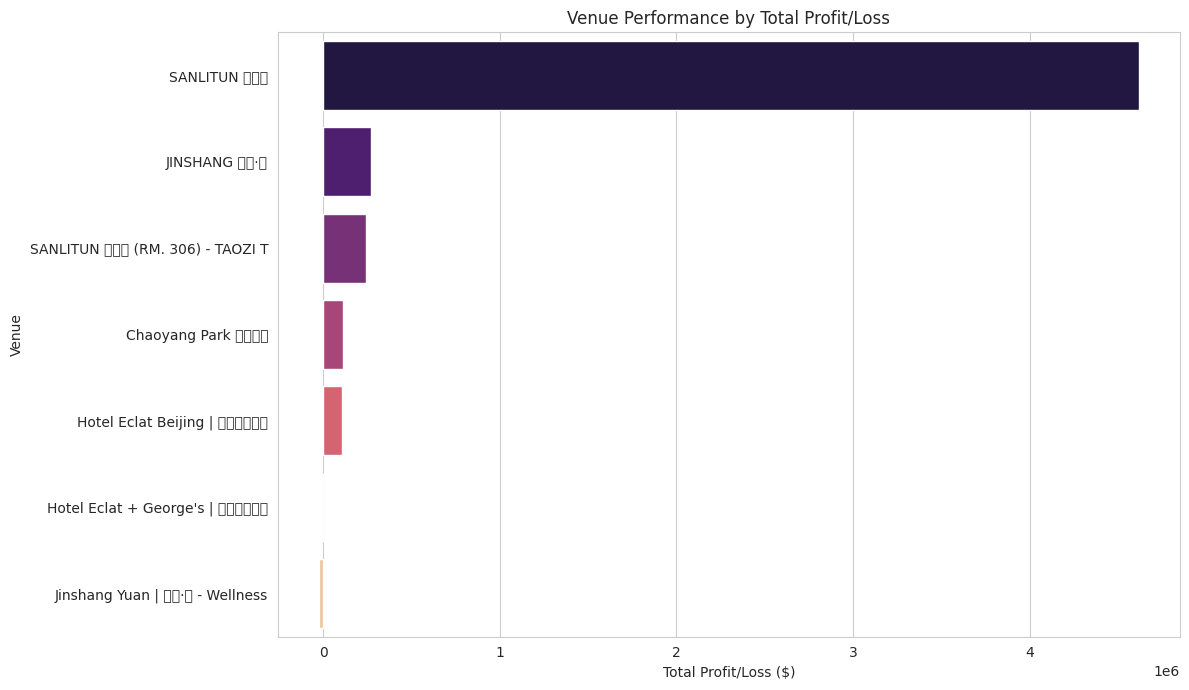

In [9]:
# Aggregate data by Venue
venue_performance = df.groupby('Venue').agg(
    num_classes=('Class___Name', 'count'),
    total_paying_students=('No_of_Paying_Students', 'sum'),
    average_paying_students_per_class=('No_of_Paying_Students', 'mean'),
    total_revenue=('Value_Per_Class', 'sum'),
    total_profit_loss=('Profit_Loss_Per_Class', 'sum'),
    average_profit_loss=('Profit_Loss_Per_Class', 'mean')
).reset_index().sort_values(by='total_paying_students', ascending=False)

print("--- Venue Performance Analysis ---")
print(venue_performance)

# Plot: Venue Performance by Total Paying Students
plt.figure(figsize=(12, 7))
sns.barplot(x='total_paying_students', y='Venue', data=venue_performance, palette='viridis')
plt.xlabel('Total Paying Students')
plt.ylabel('Venue')
plt.title('Venue Performance by Total Paying Students')
plt.tight_layout()
plt.savefig('venue_total_students.png') # Save plot
plt.show()

# Plot: Venue Performance by Total Profit/Loss
plt.figure(figsize=(12, 7))
sns.barplot(x='total_profit_loss', y='Venue', data=venue_performance, palette='magma')
plt.xlabel('Total Profit/Loss ($)')
plt.ylabel('Venue')
plt.title('Venue Performance by Total Profit/Loss')
plt.tight_layout()
plt.savefig('venue_total_profit_loss.png') # Save plot
plt.show()

--- Scheduling Optimization: Performance by Day and Time ---

Performance by Day of the Week:
         Day  num_classes  average_paying_students  \
0     Monday          268                 4.854478   
1    Tuesday          307                 5.589577   
2  Wednesday          274                 5.215328   
3   Thursday          331                 4.519637   
4     Friday          248                 5.044355   
5   Saturday          132                 7.424242   
6     Sunday           89                 7.370787   

   average_profit_loss_per_class  total_profit_loss  
0                    -409.764925          -109817.0  
1                    5676.762215          1742766.0  
2                     640.740876           175563.0  
3                    1805.504532           597622.0  
4                    1138.395161           282322.0  
5                    9504.636364          1254612.0  
6                   15556.483146          1384527.0  


/tmp/ipython-input-10-914659614.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  day_performance = df.groupby('Day').agg(
/tmp/ipython-input-10-914659614.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Day', y='average_paying_students', data=day_performance, palette='Blues_d')


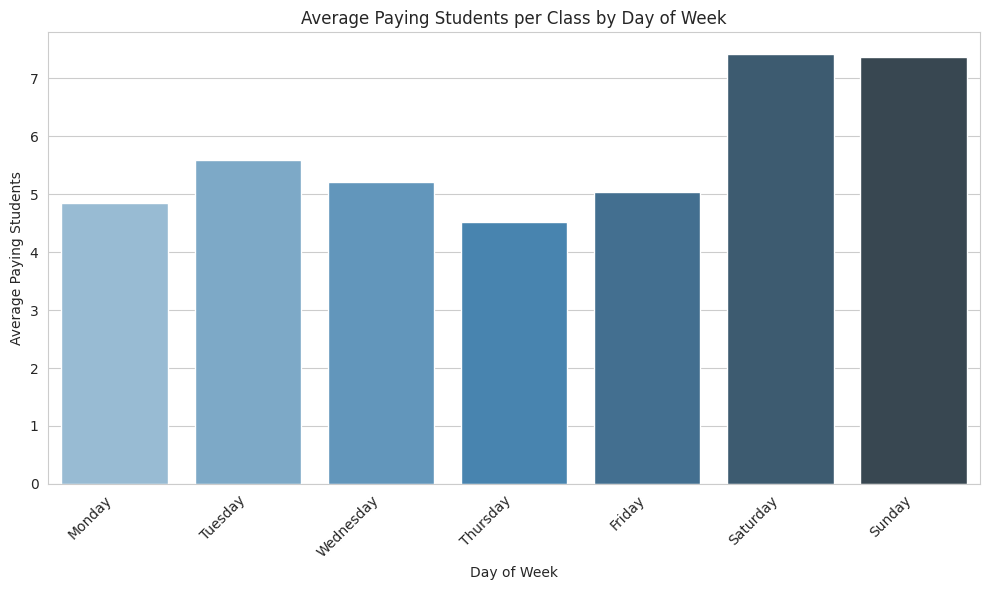

/tmp/ipython-input-10-914659614.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Day', y='average_profit_loss_per_class', data=day_performance, palette='Greens_d')


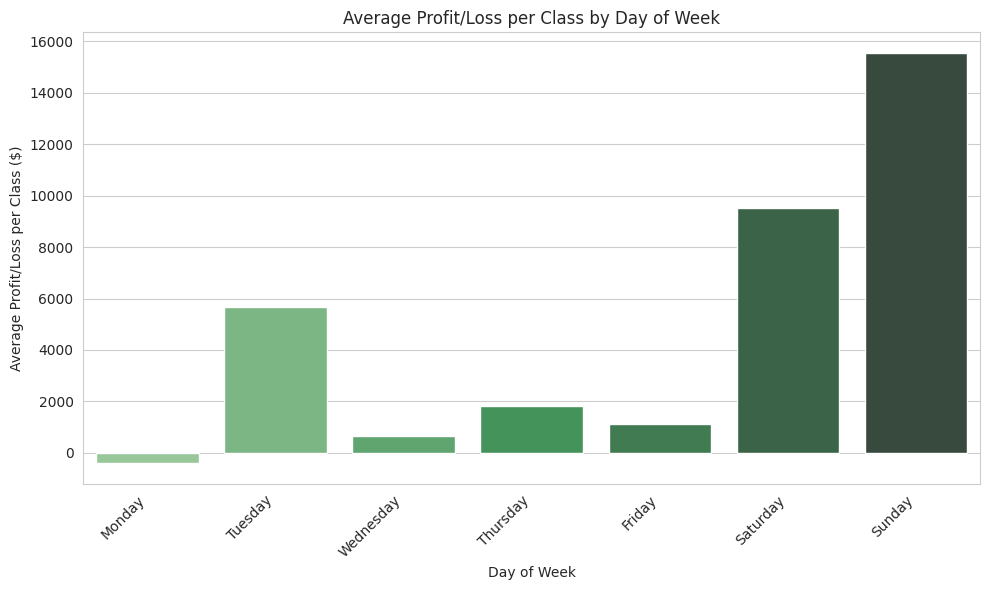

/tmp/ipython-input-10-914659614.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  time_performance = df.groupby('Time_Category').agg(



Performance by Time Category:
             Time_Category  num_classes  average_paying_students  \
0    Morning (05:00-11:59)          593                 4.251265   
1  Lunchtime (12:00-14:59)          363                 6.476584   
2  Afternoon (15:00-17:59)          239                 5.460251   
3    Evening (18:00-23:59)          454                 5.841410   
4                    Other            0                      NaN   

   average_profit_loss_per_class  total_profit_loss  
0                   -1840.129848         -1091197.0  
1                    7823.336088          2839871.0  
2                    5784.016736          1382380.0  
3                    4838.196035          2196541.0  
4                            NaN                0.0  


/tmp/ipython-input-10-914659614.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Time_Category', y='average_paying_students', data=time_performance, palette='Blues_d')


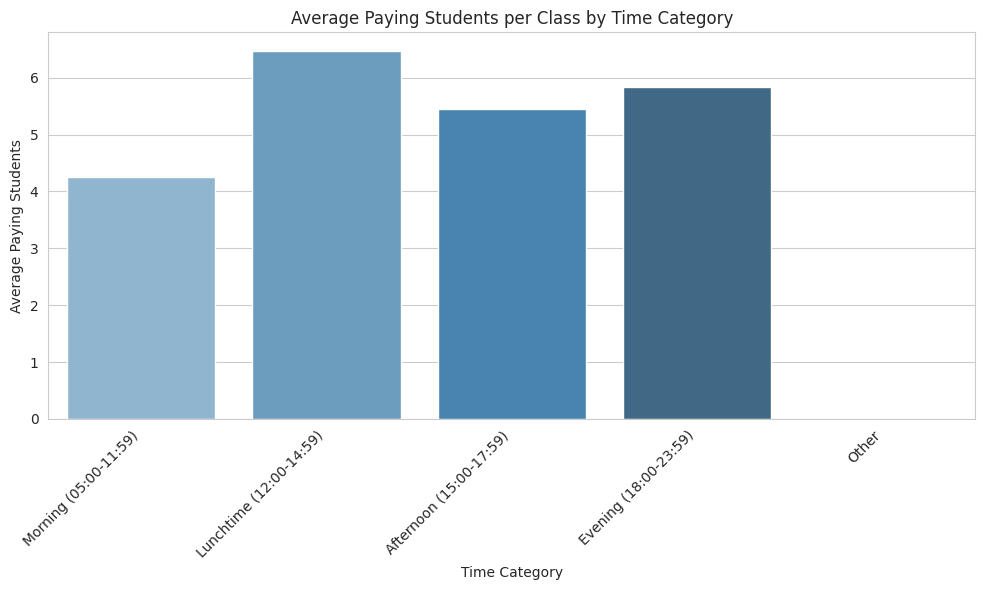

/tmp/ipython-input-10-914659614.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Time_Category', y='average_profit_loss_per_class', data=time_performance, palette='Greens_d')


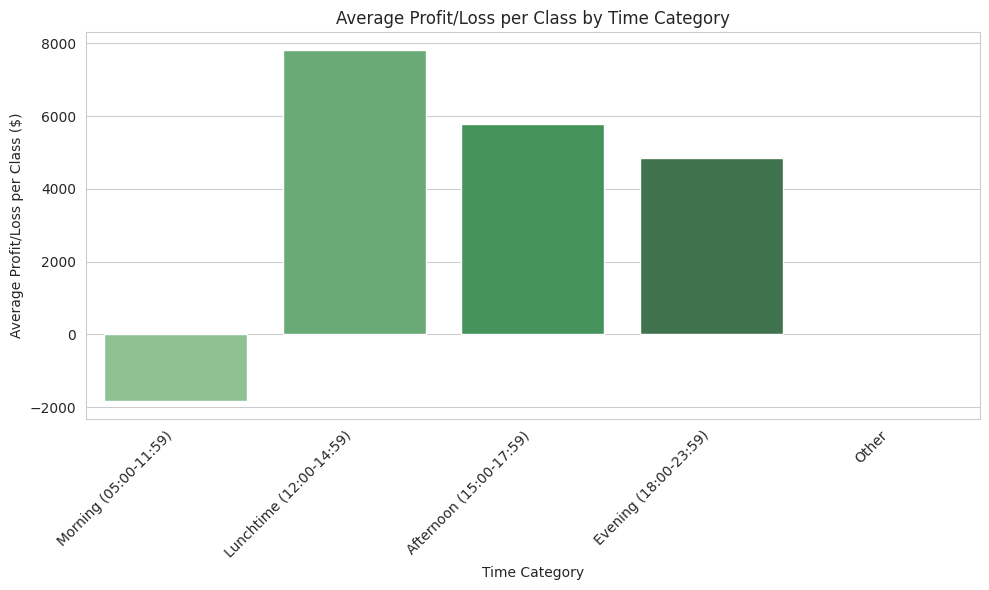

/tmp/ipython-input-10-914659614.py:70: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  day_time_performance = df.groupby(['Day', 'Time_Category']).agg(
/tmp/ipython-input-10-914659614.py:77: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_avg_students = day_time_performance.pivot_table(index='Time_Category', columns='Day', values='average_paying_students')
/tmp/ipython-input-10-914659614.py:78: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_avg_profit = day_time_perfor

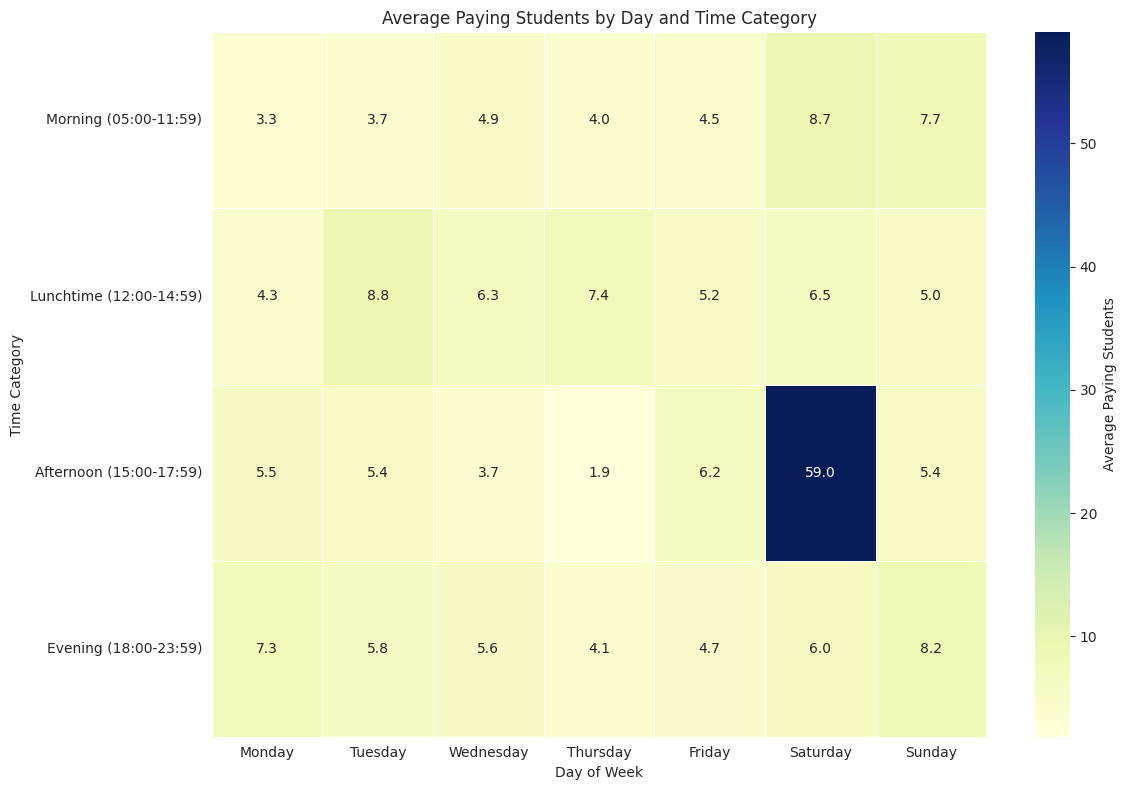

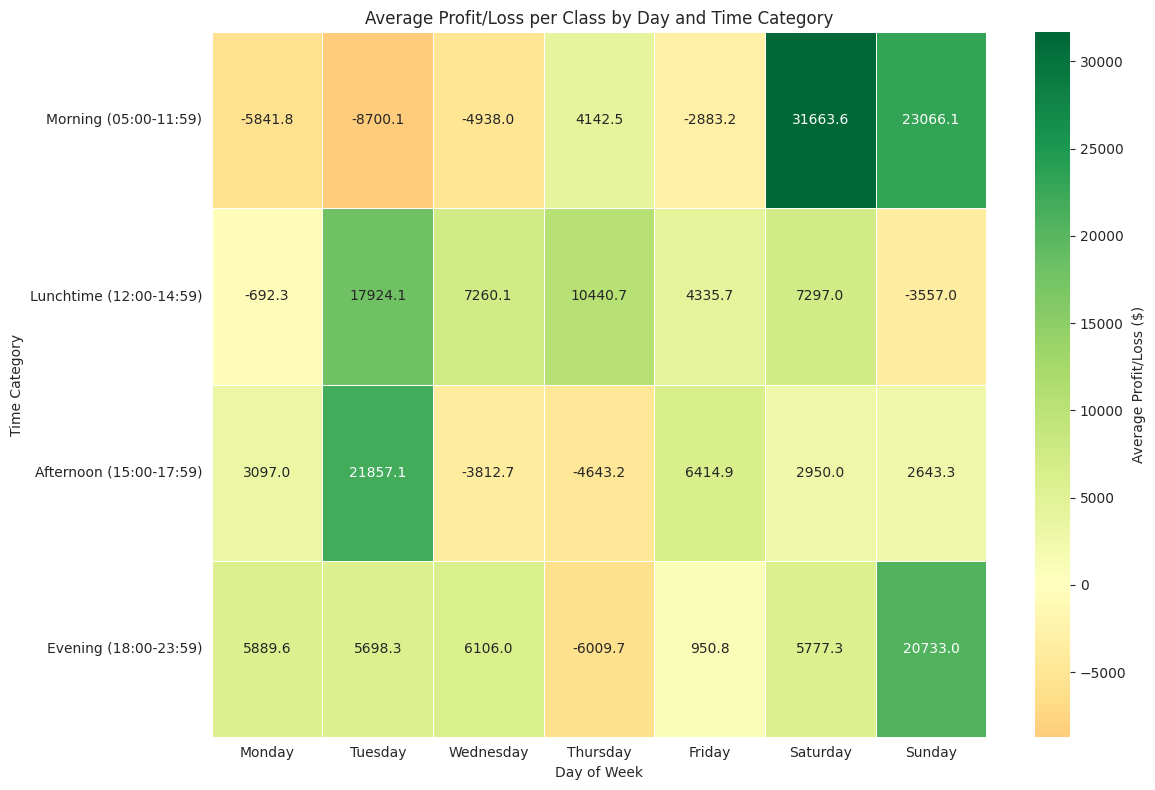

In [10]:
print("--- Scheduling Optimization: Performance by Day and Time ---")

# --- 9.1 Performance by Day of the Week ---
day_performance = df.groupby('Day').agg(
    num_classes=('Class___Name', 'count'),
    average_paying_students=('No_of_Paying_Students', 'mean'),
    average_profit_loss_per_class=('Profit_Loss_Per_Class', 'mean'),
    total_profit_loss=('Profit_Loss_Per_Class', 'sum')
).reset_index().sort_values(by='Day')

print("\nPerformance by Day of the Week:")
print(day_performance)

# Plot: Average Paying Students by Day of Week
plt.figure(figsize=(10, 6))
sns.barplot(x='Day', y='average_paying_students', data=day_performance, palette='Blues_d')
plt.xlabel('Day of Week')
plt.ylabel('Average Paying Students')
plt.title('Average Paying Students per Class by Day of Week')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('avg_students_by_day.png') # Save plot
plt.show()

# Plot: Average Profit/Loss per Class by Day of Week
plt.figure(figsize=(10, 6))
sns.barplot(x='Day', y='average_profit_loss_per_class', data=day_performance, palette='Greens_d')
plt.xlabel('Day of Week')
plt.ylabel('Average Profit/Loss per Class ($)')
plt.title('Average Profit/Loss per Class by Day of Week')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('avg_profit_by_day.png') # Save plot
plt.show()

# --- 9.2 Performance by Time Category ---
time_performance = df.groupby('Time_Category').agg(
    num_classes=('Class___Name', 'count'),
    average_paying_students=('No_of_Paying_Students', 'mean'),
    average_profit_loss_per_class=('Profit_Loss_Per_Class', 'mean'),
    total_profit_loss=('Profit_Loss_Per_Class', 'sum')
).reset_index().sort_values(by='Time_Category')

print("\nPerformance by Time Category:")
print(time_performance)

# Plot: Average Paying Students by Time Category
plt.figure(figsize=(10, 6))
sns.barplot(x='Time_Category', y='average_paying_students', data=time_performance, palette='Blues_d')
plt.xlabel('Time Category')
plt.ylabel('Average Paying Students')
plt.title('Average Paying Students per Class by Time Category')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('avg_students_by_time_category.png') # Save plot
plt.show()

# Plot: Average Profit/Loss per Class by Time Category
plt.figure(figsize=(10, 6))
sns.barplot(x='Time_Category', y='average_profit_loss_per_class', data=time_performance, palette='Greens_d')
plt.xlabel('Time Category')
plt.ylabel('Average Profit/Loss per Class ($)')
plt.title('Average Profit/Loss per Class by Time Category')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('avg_profit_by_time_category.png') # Save plot
plt.show()

# --- 9.3 Performance by Day and Time Combination (Heatmaps) ---
day_time_performance = df.groupby(['Day', 'Time_Category']).agg(
    num_classes=('Class___Name', 'count'),
    average_paying_students=('No_of_Paying_Students', 'mean'),
    average_profit_loss_per_class=('Profit_Loss_Per_Class', 'mean')
).reset_index()

# Pivot tables for heatmap visualization
pivot_avg_students = day_time_performance.pivot_table(index='Time_Category', columns='Day', values='average_paying_students')
pivot_avg_profit = day_time_performance.pivot_table(index='Time_Category', columns='Day', values='average_profit_loss_per_class')

# Heatmap for Average Paying Students
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_avg_students, annot=True, fmt=".1f", cmap="YlGnBu", linewidths=.5, cbar_kws={'label': 'Average Paying Students'})
plt.xlabel('Day of Week')
plt.ylabel('Time Category')
plt.title('Average Paying Students by Day and Time Category')
plt.tight_layout()
plt.savefig('heatmap_avg_students_day_time.png') # Save plot
plt.show()

# Heatmap for Average Profit/Loss per Class
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_avg_profit, annot=True, fmt=".1f", cmap="RdYlGn", center=0, linewidths=.5, cbar_kws={'label': 'Average Profit/Loss ($)'})
plt.xlabel('Day of Week')
plt.ylabel('Time Category')
plt.title('Average Profit/Loss per Class by Day and Time Category')
plt.tight_layout()
plt.savefig('heatmap_avg_profit_day_time.png') # Save plot
plt.show()

/tmp/ipython-input-11-3001223093.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tenure_performance = df.groupby('Tenure_Category').agg(
/tmp/ipython-input-11-3001223093.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Tenure_Category', y='average_paying_students', data=tenure_performance, palette='rocket')



--- Performance by Teacher-Class Tenure Category ---
  Tenure_Category  num_classes  average_paying_students  \
0      0-3 Months          780                 5.237179   
1      4-6 Months          403                 5.091811   
2     7-12 Months          429                 5.871795   
3  Over 12 Months           37                 4.675676   

   average_profit_loss_per_class  total_profit_loss  
0                    1803.165385          1406469.0  
1                    1624.312655           654598.0  
2                    7477.454545          3207828.0  
3                    1586.486486            58700.0  


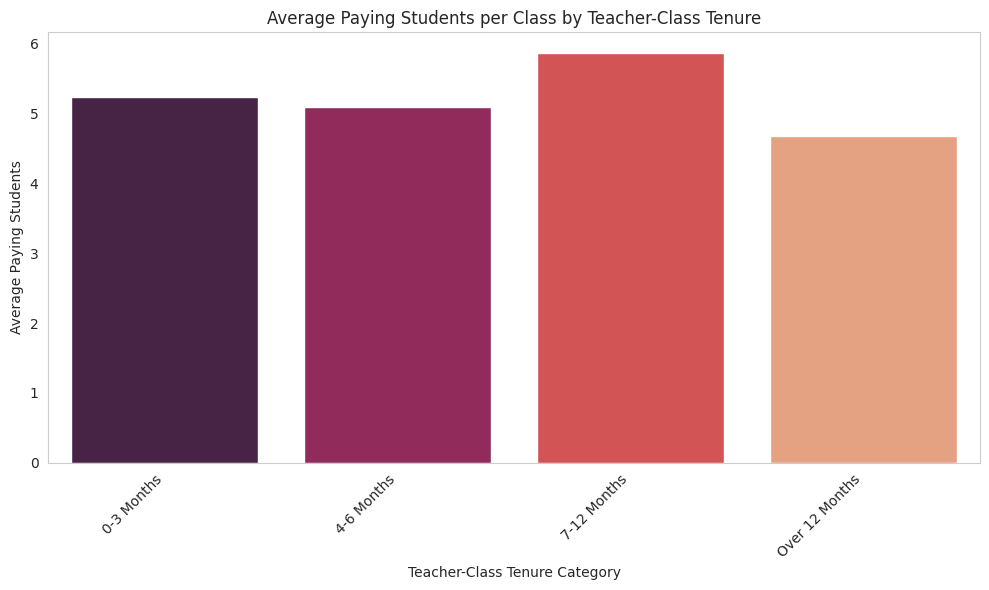

/tmp/ipython-input-11-3001223093.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Tenure_Category', y='average_profit_loss_per_class', data=tenure_performance, palette='mako')


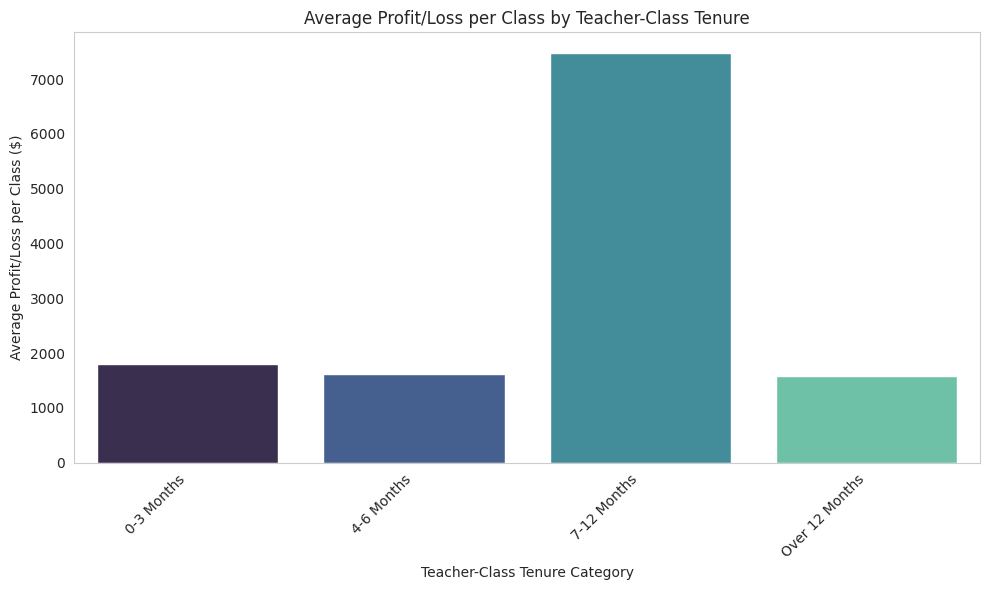

/tmp/ipython-input-11-3001223093.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  detailed_teacher_tenure_performance = df[df['Teacher'].isin(teacher_overall_avg_profit)].groupby(['Teacher', 'Tenure_Category']).agg(
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:123: UserWarning: Glyph 35199 (\N{CJK UNIFIED IDEOGRAPH-897F}) missing from font(s) DejaVu Sans.
  self._figure.tight_layout(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:123: UserWarning: Glyph 38597 (\N{CJK UNIFIED IDEOGRAPH-96C5}) missing from font(s) DejaVu Sans.
  self._figure.tight_layout(*args, **kwargs)
/tmp/ipython-input-11-3001223093.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and se

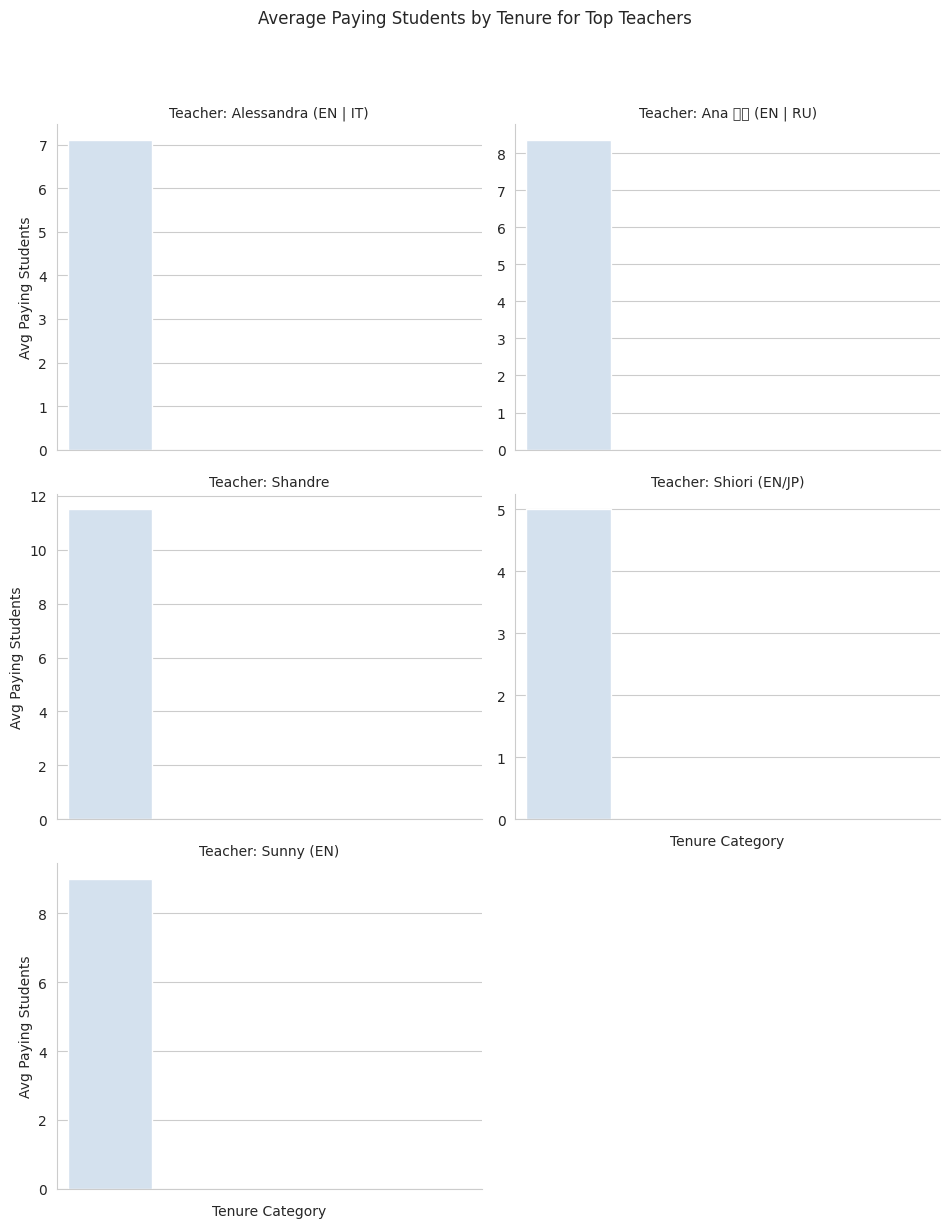

/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:123: UserWarning: Glyph 35199 (\N{CJK UNIFIED IDEOGRAPH-897F}) missing from font(s) DejaVu Sans.
  self._figure.tight_layout(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:123: UserWarning: Glyph 38597 (\N{CJK UNIFIED IDEOGRAPH-96C5}) missing from font(s) DejaVu Sans.
  self._figure.tight_layout(*args, **kwargs)
/tmp/ipython-input-11-3001223093.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g_profit = sns.catplot(
/tmp/ipython-input-11-3001223093.py:87: UserWarning: Glyph 35199 (\N{CJK UNIFIED IDEOGRAPH-897F}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.98])
/tmp/ipython-input-11-3001223093.py:87: UserWarning: Glyph 38597 (\N{CJK UNIFIED IDEOGRAPH-96C5}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.98])
/

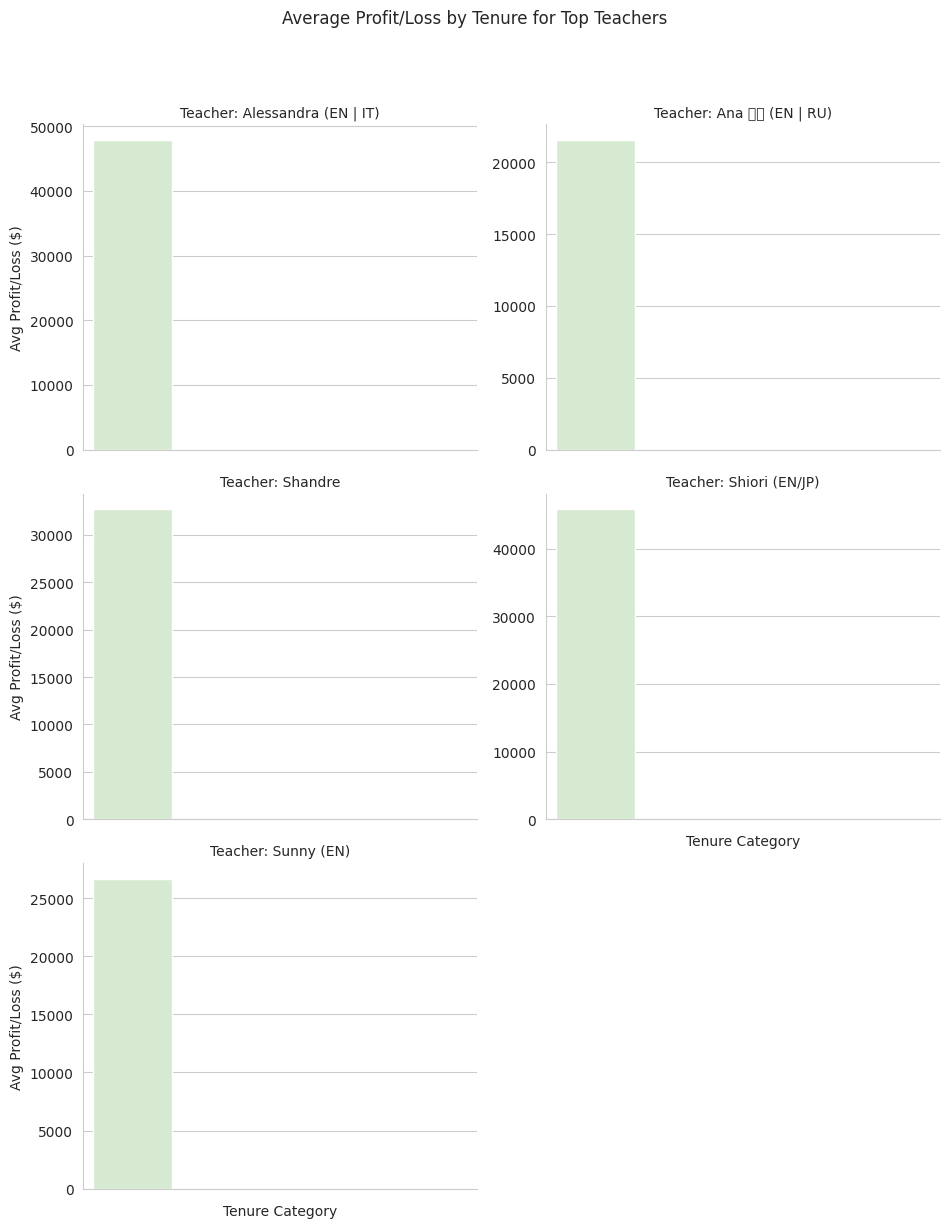

In [11]:
# --- 10.1 Teacher-Class Tenure is already calculated in Section 3.3 ---

# --- 10.2 Analyze Performance by Teacher-Class Tenure Category ---
tenure_performance = df.groupby('Tenure_Category').agg(
    num_classes=('Class___Name', 'count'),
    average_paying_students=('No_of_Paying_Students', 'mean'),
    average_profit_loss_per_class=('Profit_Loss_Per_Class', 'mean'),
    total_profit_loss=('Profit_Loss_Per_Class', 'sum')
).reset_index()

print("\n--- Performance by Teacher-Class Tenure Category ---")
print(tenure_performance)

# Plot: Average Paying Students by Teacher-Class Tenure
plt.figure(figsize=(10, 6))
sns.barplot(x='Tenure_Category', y='average_paying_students', data=tenure_performance, palette='rocket')
plt.xlabel('Teacher-Class Tenure Category')
plt.ylabel('Average Paying Students')
plt.title('Average Paying Students per Class by Teacher-Class Tenure')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.savefig('avg_students_by_tenure.png') # Save plot
plt.show()

# Plot: Average Profit/Loss per Class by Teacher-Class Tenure
plt.figure(figsize=(10, 6))
sns.barplot(x='Tenure_Category', y='average_profit_loss_per_class', data=tenure_performance, palette='mako')
plt.xlabel('Teacher-Class Tenure Category')
plt.ylabel('Average Profit/Loss per Class ($)')
plt.title('Average Profit/Loss per Class by Teacher-Class Tenure')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.savefig('avg_profit_by_tenure.png') # Save plot
plt.show()

# --- 10.3 Detailed Performance by Tenure Category for Selected Top Teachers ---
# Select top 5 teachers by average profit per class for detailed tenure analysis
# Ensure teacher_overall_avg_profit is calculated from the full teacher_performance table
teacher_overall_avg_profit = df.groupby('Teacher').agg(
    avg_profit=('Profit_Loss_Per_Class', 'mean')
).sort_values(by='avg_profit', ascending=False).head(5).index.tolist()

detailed_teacher_tenure_performance = df[df['Teacher'].isin(teacher_overall_avg_profit)].groupby(['Teacher', 'Tenure_Category']).agg(
    num_classes=('Class___Name', 'count'),
    average_paying_students=('No_of_Paying_Students', 'mean'),
    average_profit_loss_per_class=('Profit_Loss_Per_Class', 'mean')
).reset_index()

# Plot: Faceted plots for Average Paying Students by Tenure Category for Top Teachers
g_students = sns.catplot(
    data=detailed_teacher_tenure_performance,
    x='Tenure_Category',
    y='average_paying_students',
    col='Teacher',
    col_wrap=2, # Display 2 plots per row
    kind='bar',
    height=4, aspect=1.2,
    palette='Blues',
    sharey=False # Allow y-axes to vary per subplot for better comparison within each teacher's scale
)
g_students.set_axis_labels("Tenure Category", "Avg Paying Students")
g_students.set_titles("Teacher: {col_name}")
g_students.set_xticklabels(rotation=45, ha='right')
plt.suptitle('Average Paying Students by Tenure for Top Teachers', y=1.02)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.savefig('top_teachers_students_by_class_tenure_faceted.png') # Save plot
plt.show()

# Plot: Faceted plots for Average Profit/Loss per Class by Tenure Category for Top Teachers
g_profit = sns.catplot(
    data=detailed_teacher_tenure_performance,
    x='Tenure_Category',
    y='average_profit_loss_per_class',
    col='Teacher',
    col_wrap=2,
    kind='bar',
    height=4, aspect=1.2,
    palette='Greens',
    sharey=False
)
g_profit.set_axis_labels("Tenure Category", "Avg Profit/Loss ($)")
g_profit.set_titles("Teacher: {col_name}")
g_profit.set_xticklabels(rotation=45, ha='right')
plt.suptitle('Average Profit/Loss by Tenure for Top Teachers', y=1.02)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.savefig('top_teachers_profit_by_class_tenure_faceted.png') # Save plot
plt.show()